In [1]:
#!pip install tensorflow==1.13.1



In [2]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import cv2
import os
import ops
from ops import *
from utils import * 

In [3]:
import tensorflow as tf
tf.__version__

'1.13.1'

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [4]:
DATA_PATH = './img_align_celeba/' # Path to the dataset with celebA faces

Z_DIM=100 # 100 Dimension of face's manifold
GENERATOR_DENSE_SIZE=64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [5]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

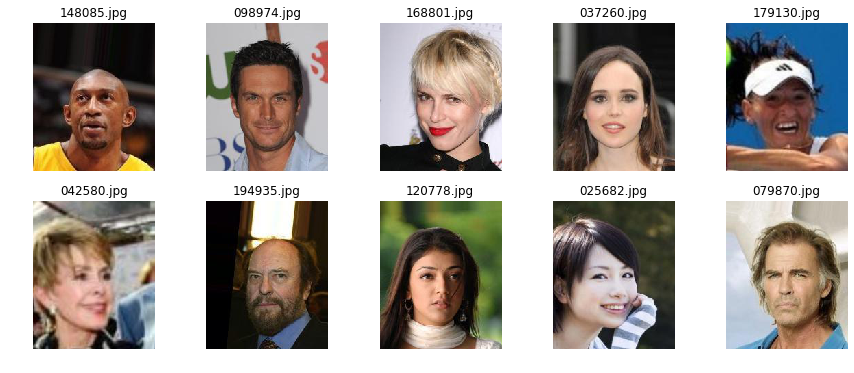

In [6]:
from os.path import join
def visualize_samples(data_path, n_cols=5, n_rows=2,crop=False):
    """Visualize samples."""
    plt.figure(figsize = (3*n_cols,3*n_rows))
    for n,i in enumerate(np.random.randint(len(os.listdir(data_path)), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        img=plt.imread(data_path+os.listdir(data_path)[i])
        plt.title(os.listdir(data_path)[i])
        if not crop:
            plt.imshow(img)
        else:
            plt.imshow(crop_and_scale(img))
    plt.show()
visualize_samples(DATA_PATH)

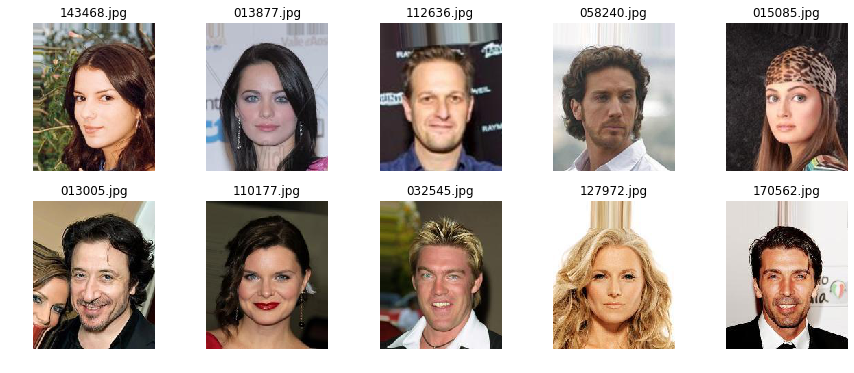

In [7]:
visualize_samples(DATA_PATH)

In [8]:
#center crop to 150*120 and resize to 64,64 the images to make them more manageable
def crop_and_scale(img):
    cropped_img=img[34:184,29:149]
    return cv2.resize(cropped_img,(64,64))

In [9]:
def transform(arr):
    arr=arr/127.5-1.
    return arr

def get_image_batch(data_path,batch_size=32):
    ret_arr=[]
    for i in np.random.randint(len(os.listdir(data_path)), size = batch_size):
        img=transform(crop_and_scale(plt.imread(data_path+os.listdir(data_path)[i])))
        ret_arr.append(img)
    return np.array(ret_arr)


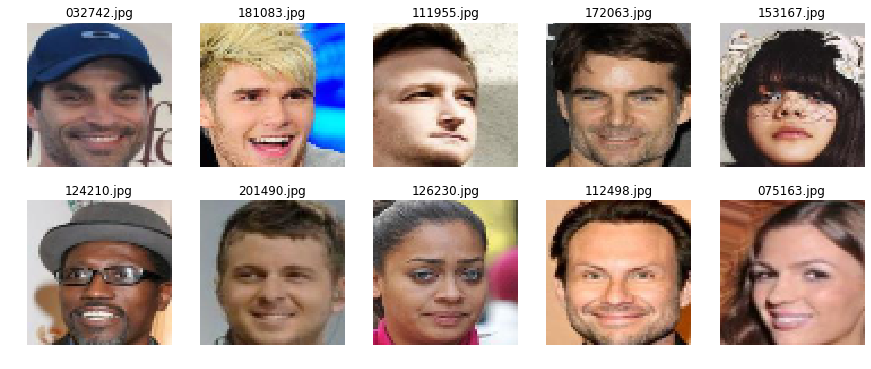

In [10]:
visualize_samples(DATA_PATH,crop=True)

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [11]:
def generator(z, is_training):
    # Firstly let's reshape input vector into 3-d tensor. 
    
    z_ = ops.linear(z, GENERATOR_DENSE_SIZE*4*4, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    g_batch_norm_in=ops.batch_norm(name='g_batch_norm_in')
    h_in_bn = g_batch_norm_in(h_in,is_training)
    h_in_z=ops.lrelu(x=h_in_bn,name='g_lr_1')

    h_1=ops.deconv2d(h_in_z,output_shape=[BATCH_SIZE,8,8,512],k_h=5,k_w=5,d_h=2, d_w=2,name="g_deconv_1")
    g_batch_norm_1=ops.batch_norm(name='g_batch_norm_1')
    h_1_bn = g_batch_norm_1(h_1,is_training)
    h_1_z=ops.lrelu(x=h_1_bn,name='g_lr_2')
    h_1_z_dr=tf.nn.dropout(h_1_z,0.3)

    h_2=ops.deconv2d(h_1_z_dr,output_shape=[BATCH_SIZE,16,16,256],k_h=5,k_w=5,d_h=2, d_w=2,name="g_deconv_2")
    g_batch_norm_2=ops.batch_norm(name='g_batch_norm_2')
    h_2_bn = g_batch_norm_2(h_2,is_training)
    h_2_z=ops.lrelu(x=h_2_bn,name='g_lr_3')
    h_2_z_dr=tf.nn.dropout(h_2_z,0.3)

    h_3=ops.deconv2d(h_2_z_dr,output_shape=[BATCH_SIZE,32,32,128],k_h=5,k_w=5,d_h=2, d_w=2,name="g_deconv_3")
    g_batch_norm_3=ops.batch_norm(name='g_batch_norm_3')
    h_3_bn = g_batch_norm_3(h_3,is_training)
    h_3_z=ops.lrelu(x=h_3_bn,name='g_lr_4')

    h_out = ops.deconv2d(h_3_z, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [12]:
def discriminator(image, is_training, batch_norms=None):

    dh_in = ops.conv2d(image,output_dim=32,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_1")
    d_batch_norm_1=ops.batch_norm(name='d_batch_norm_1')
    dh_in_bn = d_batch_norm_1(dh_in,is_training)
    dh_in_z=ops.lrelu(x=dh_in_bn,name='d_lr_1')
    
    dh_1=ops.conv2d(dh_in_z,output_dim=64,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_2")
    d_batch_norm_2=ops.batch_norm(name='d_batch_norm_2')
    dh_1_bn = d_batch_norm_2(dh_1,is_training)
    dh_1_z=ops.lrelu(x=dh_1_bn,name='d_lr_2')

    dh_2=ops.conv2d(dh_1_z,output_dim=128,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_3")
    d_batch_norm_3=ops.batch_norm(name='d_batch_norm_3')
    dh_2_bn =d_batch_norm_3(dh_2,is_training)
    dh_2_z=ops.lrelu(x=dh_2_bn,name='d_lr_3')

    dh_3=ops.conv2d(dh_2_z,output_dim=256,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_4")
    d_batch_norm_4=ops.batch_norm(name='d_batch_norm_4')
    dh_3_bn =d_batch_norm_4(dh_3,is_training)
    dh_3_z=ops.lrelu(x=dh_3_bn,name='d_lr_4')

    dh_4=ops.conv2d(dh_3_z,output_dim=512,k_h=5,k_w=5,d_h=2, d_w=2,name="d_conv_5")
    d_batch_norm_5=ops.batch_norm(name='d_batch_norm_5')
    dh_4_bn =d_batch_norm_5(dh_4,is_training)
    dh_4_z=ops.lrelu(x=dh_4_bn,name='d_lr_5')

    d_flat=tf.contrib.layers.flatten(dh_3_z)

    d_linear=ops.linear(d_flat, 256, 'd_lin_1')
    d_batch_norm_6=ops.batch_norm(name='d_batch_norm_6')
    d_linear_bn=d_batch_norm_6(d_linear,is_training)
    d_linear_z=ops.lrelu(x=d_linear_bn,name='d_lr_6')


    linear_out=ops.linear(d_linear_z,1,'d_lin_out')

    return tf.nn.sigmoid(linear_out), linear_out

In [13]:
2

2

Now let's define generator and discriminator.

In [14]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    #scope.reuse_variables()
    G = generator(z, is_training)
    
with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    
    # If you use batch norms from ops define them here (like batch_norms = [batch_norm(name='d_bn0')])
    # and pass to discriminator function instances.
    D_real, D_real_logits = discriminator(images, is_training)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training)

Instructions for updating:
Colocations handled automatically by placer.


/usr/lib/python3/dist-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.


In [15]:
tf.__version__

'1.13.1'

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [16]:

"""
        You code goes here. Define discriminator and generator losses
"""
d_loss_real = -tf.reduce_mean(tf.log_sigmoid(D_real_logits))

d_loss_fake = -tf.reduce_mean(tf.log(1-D_fake+1e-30))

surity1=np.random.uniform(0.8,1.15) #label smoothing
surity2=np.random.uniform(-1.0,0.2)

d_loss = surity1*d_loss_real + (1-surity2)*d_loss_fake

g_loss = -tf.reduce_mean(tf.log_sigmoid(D_fake_logits))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [17]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars)

Load data:

In [18]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))
print(len(data))
assert(len(data) > 0), "Length of training data should be more than zero"

202599


In [19]:
data

['./img_align_celeba/009974.jpg',
 './img_align_celeba/198257.jpg',
 './img_align_celeba/169230.jpg',
 './img_align_celeba/023856.jpg',
 './img_align_celeba/189367.jpg',
 './img_align_celeba/201507.jpg',
 './img_align_celeba/101242.jpg',
 './img_align_celeba/173788.jpg',
 './img_align_celeba/122345.jpg',
 './img_align_celeba/062025.jpg',
 './img_align_celeba/019624.jpg',
 './img_align_celeba/170544.jpg',
 './img_align_celeba/036671.jpg',
 './img_align_celeba/097696.jpg',
 './img_align_celeba/173266.jpg',
 './img_align_celeba/156470.jpg',
 './img_align_celeba/131051.jpg',
 './img_align_celeba/009134.jpg',
 './img_align_celeba/006722.jpg',
 './img_align_celeba/177868.jpg',
 './img_align_celeba/076414.jpg',
 './img_align_celeba/109159.jpg',
 './img_align_celeba/123557.jpg',
 './img_align_celeba/168097.jpg',
 './img_align_celeba/047616.jpg',
 './img_align_celeba/043909.jpg',
 './img_align_celeba/114537.jpg',
 './img_align_celeba/173598.jpg',
 './img_align_celeba/188891.jpg',
 './img_align_

Functions for training and evaluations.

In [20]:
# def load(sess, load_dir,latest_fname=None):
#     """load network's paramaters                                                                                                                                                  
                                                                                                                                                                                  
#     load_dir : path to load dir                                                                                                                                                   
#     """
#     saver = tf.train.Saver()
#     #    ckpt = tf.train.get_checkpoint_state(load_dir,latest_filename=latest_fname)                                                                                              
#     #   if ckpt and ckpt.model_checkpoint_path:                                                                                                                                   
#     #          saver.restore(sess, ckpt.model_checkpoint_path)                                                                                                                    
#     saver.restore(sess,os.path.join(load_dir,latest_fname))
    
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

## Training GAN (1 point + 2 for good results)

In [21]:
def train(sess, load_dir=None, save_frequency=100, sample_frequency=100, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=10, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs =100# 100 min(len(data), np.inf) // BATCH_SIZE
        
        for idx in range(batch_idxs):
           # batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
           #batch = [get_image(batch_file, IMAGE_SIZE) for batch_file in batch_files]
           # batch_images = np.array(batch).astype(np.float32)
            batch_images=get_image_batch(DATA_PATH,BATCH_SIZE)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z, is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples, [MERGE_X, MERGE_X],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sampled") 

In [22]:
#with tf.Session() as sess:
#    train(sess, save_dir='checkpoint')#remove load_dir

Epoch: [ 0] [   0/ 100] time: 20.8246, d_loss: 1.38687587, g_loss: 0.67018974
Epoch: [ 0] [   1/ 100] time: 36.5956, d_loss: 1.38856912, g_loss: 0.65328217
Epoch: [ 0] [   2/ 100] time: 52.7715, d_loss: 1.39289927, g_loss: 0.63495791
Epoch: [ 0] [   3/ 100] time: 69.2376, d_loss: 1.40023720, g_loss: 0.62144327
Epoch: [ 0] [   4/ 100] time: 84.1541, d_loss: 1.40111494, g_loss: 0.61193711
Epoch: [ 0] [   5/ 100] time: 101.3605, d_loss: 1.40673244, g_loss: 0.60715699
Epoch: [ 0] [   6/ 100] time: 117.4711, d_loss: 1.40635133, g_loss: 0.60918283
Epoch: [ 0] [   7/ 100] time: 138.2592, d_loss: 1.40095592, g_loss: 0.61923522
Epoch: [ 0] [   8/ 100] time: 162.2811, d_loss: 1.39999521, g_loss: 0.63695252
Epoch: [ 0] [   9/ 100] time: 185.4194, d_loss: 1.40307474, g_loss: 0.64120471
Epoch: [ 0] [  10/ 100] time: 209.3837, d_loss: 1.42585826, g_loss: 0.65806252
Epoch: [ 0] [  11/ 100] time: 232.2172, d_loss: 1.43773818, g_loss: 0.66209161
Epoch: [ 0] [  12/ 100] time: 255.6509, d_loss: 1.4413945

Epoch: [ 1] [   3/ 100] time: 1706.0120, d_loss: 1.31078804, g_loss: 0.90130341
Epoch: [ 1] [   4/ 100] time: 1722.2174, d_loss: 1.34620214, g_loss: 0.93696147
Epoch: [ 1] [   5/ 100] time: 1737.8327, d_loss: 0.90396893, g_loss: 0.81430006
Epoch: [ 1] [   6/ 100] time: 1754.4638, d_loss: 1.50428486, g_loss: 0.88116944
Epoch: [ 1] [   7/ 100] time: 1772.8933, d_loss: 1.78732944, g_loss: 0.88547736
Epoch: [ 1] [   8/ 100] time: 1790.1296, d_loss: 1.24954939, g_loss: 0.82472503
Epoch: [ 1] [   9/ 100] time: 1805.6800, d_loss: 1.00745797, g_loss: 0.82591206
Epoch: [ 1] [  10/ 100] time: 1820.8733, d_loss: 0.88580662, g_loss: 0.86588305
Epoch: [ 1] [  11/ 100] time: 1843.3064, d_loss: 1.10698640, g_loss: 0.83567375
Epoch: [ 1] [  12/ 100] time: 1866.0770, d_loss: 1.34029722, g_loss: 0.76119542
Epoch: [ 1] [  13/ 100] time: 1888.4280, d_loss: 1.06417727, g_loss: 0.76428890
Epoch: [ 1] [  14/ 100] time: 1909.3556, d_loss: 0.93445247, g_loss: 0.71472579
Epoch: [ 1] [  15/ 100] time: 1930.5910,

Epoch: [ 2] [   6/ 100] time: 3582.3314, d_loss: 0.99083382, g_loss: 0.85985744
Epoch: [ 2] [   7/ 100] time: 3598.3691, d_loss: 1.15783978, g_loss: 0.90121710
Epoch: [ 2] [   8/ 100] time: 3614.0922, d_loss: 1.12897265, g_loss: 0.81593388
Epoch: [ 2] [   9/ 100] time: 3631.2424, d_loss: 0.99795711, g_loss: 0.74177849
Epoch: [ 2] [  10/ 100] time: 3648.7551, d_loss: 0.85912758, g_loss: 0.79729855
Epoch: [ 2] [  11/ 100] time: 3666.1789, d_loss: 1.35014582, g_loss: 0.50819844
Epoch: [ 2] [  12/ 100] time: 3683.5386, d_loss: 1.09548223, g_loss: 0.68254441
Epoch: [ 2] [  13/ 100] time: 3700.8061, d_loss: 0.99831569, g_loss: 0.73137844
Epoch: [ 2] [  14/ 100] time: 3718.2987, d_loss: 0.90365517, g_loss: 0.95434618
Epoch: [ 2] [  15/ 100] time: 3735.7671, d_loss: 2.29974532, g_loss: 0.43481719
Epoch: [ 2] [  16/ 100] time: 3752.9834, d_loss: 1.51529026, g_loss: 0.44382694
Epoch: [ 2] [  17/ 100] time: 3770.3291, d_loss: 1.41957855, g_loss: 0.56979483
Epoch: [ 2] [  18/ 100] time: 3789.2900,

Epoch: [ 3] [   9/ 100] time: 5602.4173, d_loss: 1.56572199, g_loss: 1.11371839
Epoch: [ 3] [  10/ 100] time: 5617.1607, d_loss: 1.21800423, g_loss: 1.40668428
Epoch: [ 3] [  11/ 100] time: 5631.8802, d_loss: 1.50010824, g_loss: 1.03577137
Epoch: [ 3] [  12/ 100] time: 5646.7380, d_loss: 1.56510556, g_loss: 1.16964769
Epoch: [ 3] [  13/ 100] time: 5661.3554, d_loss: 1.35206759, g_loss: 1.35935640
Epoch: [ 3] [  14/ 100] time: 5676.2096, d_loss: 1.52916908, g_loss: 0.91968608
Epoch: [ 3] [  15/ 100] time: 5690.8835, d_loss: 1.69776762, g_loss: 0.95816487
Epoch: [ 3] [  16/ 100] time: 5705.5385, d_loss: 1.06109035, g_loss: 1.52614188
Epoch: [ 3] [  17/ 100] time: 5720.1420, d_loss: 1.93798351, g_loss: 0.62050682
Epoch: [ 3] [  18/ 100] time: 5735.0852, d_loss: 2.30862975, g_loss: 0.59429687
Epoch: [ 3] [  19/ 100] time: 5749.6848, d_loss: 1.96487784, g_loss: 0.70200580
Epoch: [ 3] [  20/ 100] time: 5764.2710, d_loss: 1.54914248, g_loss: 0.71164495
Epoch: [ 3] [  21/ 100] time: 5779.9801,

Epoch: [ 4] [  12/ 100] time: 7205.0358, d_loss: 1.54365301, g_loss: 0.81205440
Epoch: [ 4] [  13/ 100] time: 7220.4744, d_loss: 1.58339167, g_loss: 0.88340139
Epoch: [ 4] [  14/ 100] time: 7238.4430, d_loss: 1.16702664, g_loss: 1.23422837
Epoch: [ 4] [  15/ 100] time: 7255.5485, d_loss: 1.26781189, g_loss: 1.02782917
Epoch: [ 4] [  16/ 100] time: 7272.7598, d_loss: 1.39214659, g_loss: 0.86340588
Epoch: [ 4] [  17/ 100] time: 7288.8885, d_loss: 1.51067591, g_loss: 0.78014958
Epoch: [ 4] [  18/ 100] time: 7304.6500, d_loss: 1.53242898, g_loss: 0.81872356
Epoch: [ 4] [  19/ 100] time: 7319.8458, d_loss: 1.41536081, g_loss: 1.02321041
Epoch: [ 4] [  20/ 100] time: 7335.3079, d_loss: 1.36051536, g_loss: 1.05662799
Epoch: [ 4] [  21/ 100] time: 7351.0755, d_loss: 1.44927824, g_loss: 0.86604470
Epoch: [ 4] [  22/ 100] time: 7367.6134, d_loss: 1.40076041, g_loss: 0.87005460
Epoch: [ 4] [  23/ 100] time: 7384.2839, d_loss: 1.40564251, g_loss: 0.93935561
Epoch: [ 4] [  24/ 100] time: 7400.8482,

Epoch: [ 5] [  15/ 100] time: 8849.6016, d_loss: 1.42535162, g_loss: 0.86747277
Epoch: [ 5] [  16/ 100] time: 8865.3419, d_loss: 1.41995645, g_loss: 0.83384621
Epoch: [ 5] [  17/ 100] time: 8880.8354, d_loss: 1.34365499, g_loss: 0.86043429
Epoch: [ 5] [  18/ 100] time: 8896.4090, d_loss: 1.25343037, g_loss: 0.93061900
Epoch: [ 5] [  19/ 100] time: 8911.2681, d_loss: 1.27930593, g_loss: 0.98336083
Epoch: [ 5] [  20/ 100] time: 8926.1025, d_loss: 1.50928330, g_loss: 0.88990748
Epoch: [ 5] [  21/ 100] time: 8941.1088, d_loss: 1.42895293, g_loss: 1.02509820
Epoch: [ 5] [  22/ 100] time: 8955.9383, d_loss: 1.36566210, g_loss: 0.99383932
Epoch: [ 5] [  23/ 100] time: 8970.9665, d_loss: 1.38408136, g_loss: 0.83962369
Epoch: [ 5] [  24/ 100] time: 8986.3910, d_loss: 1.39152324, g_loss: 0.88786221
Epoch: [ 5] [  25/ 100] time: 9003.3833, d_loss: 1.39414299, g_loss: 0.91716194
Epoch: [ 5] [  26/ 100] time: 9020.3788, d_loss: 1.45892346, g_loss: 0.93152499
Epoch: [ 5] [  27/ 100] time: 9036.0833,

Epoch: [ 6] [  17/ 100] time: 10491.9826, d_loss: 1.23645782, g_loss: 0.92070216
Epoch: [ 6] [  18/ 100] time: 10509.0814, d_loss: 1.26274347, g_loss: 0.96169001
Epoch: [ 6] [  19/ 100] time: 10524.4019, d_loss: 1.26408625, g_loss: 0.94936204
Epoch: [ 6] [  20/ 100] time: 10541.6914, d_loss: 1.29755950, g_loss: 0.92973375
Epoch: [ 6] [  21/ 100] time: 10560.6051, d_loss: 1.43801022, g_loss: 0.83999747
Epoch: [ 6] [  22/ 100] time: 10576.5002, d_loss: 1.41308200, g_loss: 0.92157537
Epoch: [ 6] [  23/ 100] time: 10591.7895, d_loss: 1.32191420, g_loss: 0.94078398
Epoch: [ 6] [  24/ 100] time: 10607.0039, d_loss: 1.36561203, g_loss: 0.90787274
Epoch: [ 6] [  25/ 100] time: 10622.3372, d_loss: 1.33019567, g_loss: 0.98931968
Epoch: [ 6] [  26/ 100] time: 10637.7753, d_loss: 1.37449861, g_loss: 0.91966343
Epoch: [ 6] [  27/ 100] time: 10653.1904, d_loss: 1.48772502, g_loss: 0.80970562
Epoch: [ 6] [  28/ 100] time: 10668.5054, d_loss: 1.34805143, g_loss: 0.99733657
Epoch: [ 6] [  29/ 100] time

Epoch: [ 7] [  18/ 100] time: 12105.2046, d_loss: 1.41285455, g_loss: 0.83579189
Epoch: [ 7] [  19/ 100] time: 12119.7957, d_loss: 1.38121593, g_loss: 0.85986716
Epoch: [ 7] [  20/ 100] time: 12134.8584, d_loss: 1.25566030, g_loss: 0.97109008
Epoch: [ 7] [  21/ 100] time: 12151.7669, d_loss: 1.36599422, g_loss: 0.94187391
Epoch: [ 7] [  22/ 100] time: 12169.7114, d_loss: 1.35725975, g_loss: 0.95676994
Epoch: [ 7] [  23/ 100] time: 12185.2559, d_loss: 1.36450207, g_loss: 1.01903415
Epoch: [ 7] [  24/ 100] time: 12200.5658, d_loss: 1.38584578, g_loss: 0.98160481
Epoch: [ 7] [  25/ 100] time: 12215.5736, d_loss: 1.34215760, g_loss: 0.98741734
Epoch: [ 7] [  26/ 100] time: 12230.2661, d_loss: 1.30880666, g_loss: 0.96326518
Epoch: [ 7] [  27/ 100] time: 12245.3175, d_loss: 1.34734488, g_loss: 0.94388092
Epoch: [ 7] [  28/ 100] time: 12260.1656, d_loss: 1.33709550, g_loss: 0.97541666
Epoch: [ 7] [  29/ 100] time: 12275.2990, d_loss: 1.39058495, g_loss: 0.81017673
Epoch: [ 7] [  30/ 100] time

Epoch: [ 8] [  19/ 100] time: 14092.7880, d_loss: 1.25041032, g_loss: 0.94018340
Epoch: [ 8] [  20/ 100] time: 14120.4891, d_loss: 1.28610945, g_loss: 0.93367833
Epoch: [ 8] [  21/ 100] time: 14145.2495, d_loss: 1.30546546, g_loss: 0.86414194
Epoch: [ 8] [  22/ 100] time: 14169.0730, d_loss: 1.29781747, g_loss: 0.89520609
Epoch: [ 8] [  23/ 100] time: 14192.7410, d_loss: 1.34770489, g_loss: 0.91953778
Epoch: [ 8] [  24/ 100] time: 14217.3100, d_loss: 1.35938835, g_loss: 0.94173455
Epoch: [ 8] [  25/ 100] time: 14242.2838, d_loss: 1.29855490, g_loss: 0.90808779
Epoch: [ 8] [  26/ 100] time: 14267.5158, d_loss: 1.28936005, g_loss: 0.91736889
Epoch: [ 8] [  27/ 100] time: 14291.1663, d_loss: 1.32741857, g_loss: 0.85135710
Epoch: [ 8] [  28/ 100] time: 14315.5868, d_loss: 1.32099867, g_loss: 0.88814926
Epoch: [ 8] [  29/ 100] time: 14340.8433, d_loss: 1.29958010, g_loss: 0.91423810
Epoch: [ 8] [  30/ 100] time: 14364.9957, d_loss: 1.35010290, g_loss: 0.84906280
Epoch: [ 8] [  31/ 100] time

Epoch: [ 9] [  20/ 100] time: 16136.0679, d_loss: 1.25269830, g_loss: 0.95093906
Epoch: [ 9] [  21/ 100] time: 16159.0391, d_loss: 1.34845471, g_loss: 0.95103240
Epoch: [ 9] [  22/ 100] time: 16183.0061, d_loss: 1.40070152, g_loss: 1.00434148
Epoch: [ 9] [  23/ 100] time: 16206.7232, d_loss: 1.32074475, g_loss: 1.01398635
Epoch: [ 9] [  24/ 100] time: 16230.6642, d_loss: 1.26903474, g_loss: 0.95804608
Epoch: [ 9] [  25/ 100] time: 16253.7189, d_loss: 1.23293662, g_loss: 0.89280266
Epoch: [ 9] [  26/ 100] time: 16276.0414, d_loss: 1.24182081, g_loss: 0.97617078
Epoch: [ 9] [  27/ 100] time: 16298.1665, d_loss: 1.23564661, g_loss: 1.02085042
Epoch: [ 9] [  28/ 100] time: 16321.8159, d_loss: 1.21233392, g_loss: 1.02496290
Epoch: [ 9] [  29/ 100] time: 16345.7903, d_loss: 1.17820787, g_loss: 0.94745797
Epoch: [ 9] [  30/ 100] time: 16370.2352, d_loss: 1.22776258, g_loss: 0.95190960
Epoch: [ 9] [  31/ 100] time: 16394.2533, d_loss: 1.30731988, g_loss: 0.89932650
Epoch: [ 9] [  32/ 100] time

In [32]:
sess=tf.Session()
load(sess, load_dir='checkpoint') 
    
#with tf.Session() as sess: 
#    train(sess, save_dir='checkpoint',sample_frequency=2,model_name='dcgan.model',n_epochs=1) 

INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


In [24]:
ls

celeba-dataset/     img_align_celeba/      new_samples/   Untitled.ipynb
celeba-dataset.zip  img_align_celeba1/     ops.py         utils.py
checkpoint/         img_align_celeba.zip   __pycache__/
gan_faces.ipynb     interpolated_samples/  sample_faces/


In [33]:
new_samples = 100 # 10 batches
counter = 0
new_samples_dir = 'new_samples'
for idx in range(new_samples):    
    batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
    samples = sess.run(G, feed_dict={z: batch_z, is_training: False})
    for sample in samples:
        plt.imsave(os.path.join(new_samples_dir, 'sample_'+str(counter)+'.png'), (255*inverse_transform(sample)).astype(np.uint8))
        counter += 1
        
        
# #generate some new samples
# new_samples=100# 100 batches
# counter=0
# for idx in range(new_samples):
    
    
#     batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
#     samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
#     for sample in samples:
#         plt.imsave("new_samples/new_sample"+str(counter), (255*inverse_transform(sample)).astype(np.uint8))
#         counter+=1

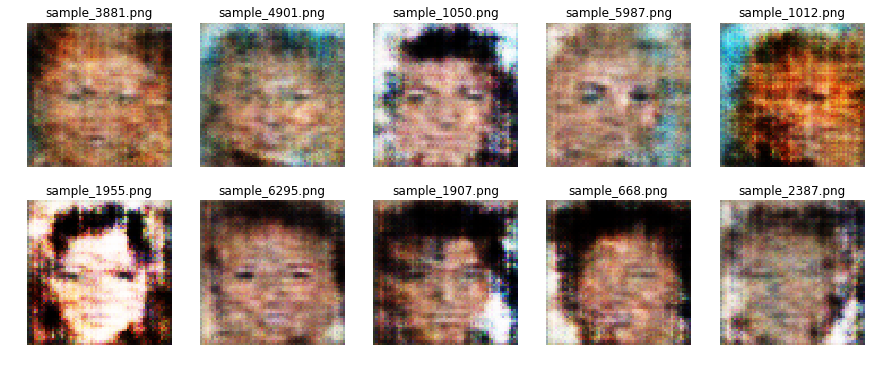

In [34]:
#visualize(new_samples_dir, n_cols=5, n_rows=2)
visualize_samples('./new_samples/',crop=False)  


If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

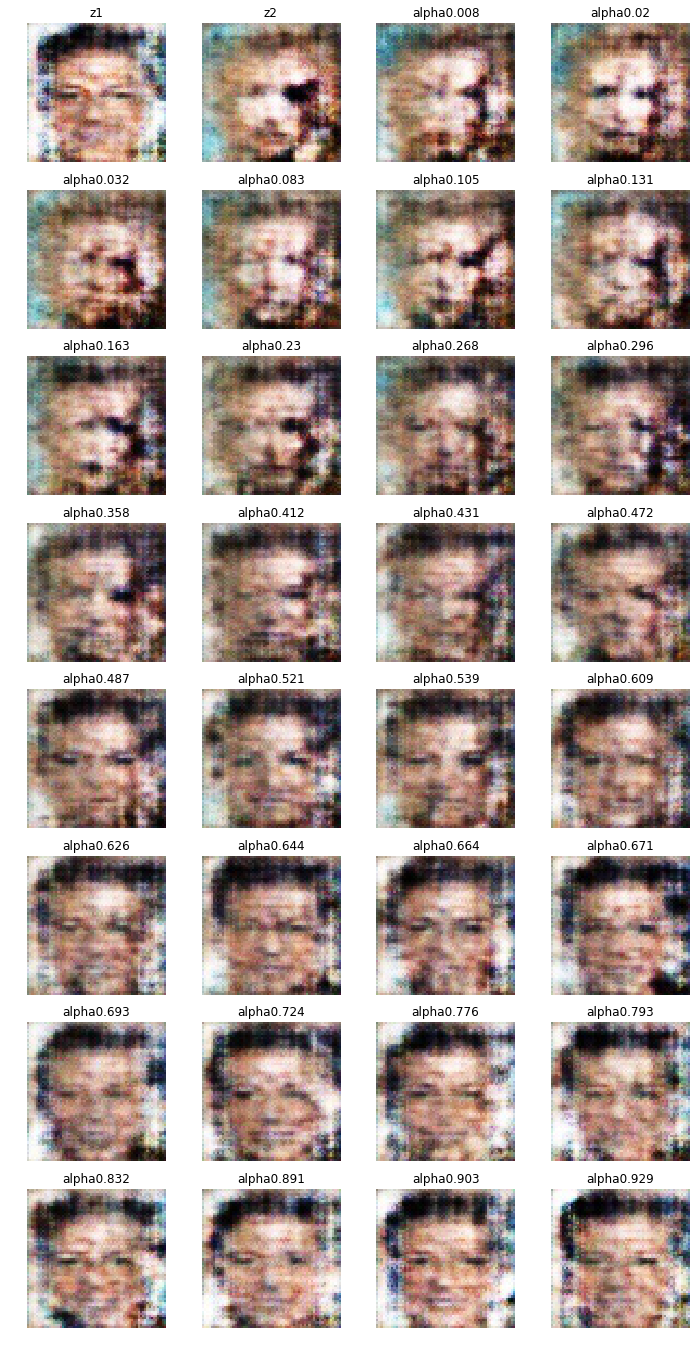

In [27]:
# zs = np.random.uniform(-1, 1, [2, Z_DIM]).astype(np.float32)
# alphas = np.linspace(0, 1, BATCH_SIZE)
# batchz = np.zeros((BATCH_SIZE, Z_DIM))
# for i, alpha in enumerate(alphas):
#     batchz[i] = alpha*zs[0] + (1 - alpha)*zs[1]
# samples = sess.run(G, feed_dict={z: batchz, is_training: False})
# interpolation_dir = 'face_interpolation'
# names = []
# for i, sample in enumerate(samples):
#     if i == 0:
#         filename = 'z2.png'
#         names.append(filename)
#     elif i == len(samples) - 1:
#         filename = 'z1.png'
#         names.append(filename)
#     else:
#         filename = 'alpha_' + str(round(alphas[i], 3)) + '.png'
#         if i&1 == 0 and i != len(samples) - 2:
#             names.append(filename)
#     plt.imsave(os.path.join(interpolation_dir, filename), (255*inverse_transform(sample)).astype(np.uint8))

# plt.figure(figsize=(16, 24))
# for i, name in enumerate(names):
#     plt.subplot(8, 4, i+1)
#     plt.axis('off')
#     img = plt.imread(join(interpolation_dir, name))
#     plt.imshow(img)
#     plt.title(name)
# plt.show()

batch_z_template = np.random.uniform(-1, 1, [2, Z_DIM]).astype(np.float32)
alpha=np.sort(np.random.uniform(high=1,low=0,size=62))
for i in range(62):
    batch=alpha[i]*batch_z_template[0]+(1-alpha[i])*batch_z_template[1]
    batch_z_template=np.vstack([batch_z_template,batch])

samples = sess.run(G, feed_dict={z: batch_z_template, is_training: False} )
for i in range(len(samples)):
    if i==0:
        plt.imsave("interpolated_samples/z1.jpg", (255*inverse_transform(samples[i])).astype(np.uint8))
    elif i==1:
        plt.imsave("interpolated_samples/z2.jpg", (255*inverse_transform(samples[i])).astype(np.uint8))
    else:
        plt.imsave("interpolated_samples/alpha"+str(round(alpha[i-2],3))+".jpg",(255*inverse_transform(samples[i])).astype(np.uint8))

names=['z1.jpg','z2.jpg']+["alpha"+str(round(alpha[i],3))+".jpg" for i in range(len(alpha)) if i%2==0]
plt.figure(figsize = (12,24))
for j in range(len(names)-1):
    plt.subplot(8,4,j+1)
    plt.axis('off')
    img=plt.imread("interpolated_samples/"+names[j])
    plt.title(names[j].replace('.jpg',''))
    plt.imshow(img)
plt.show() 

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

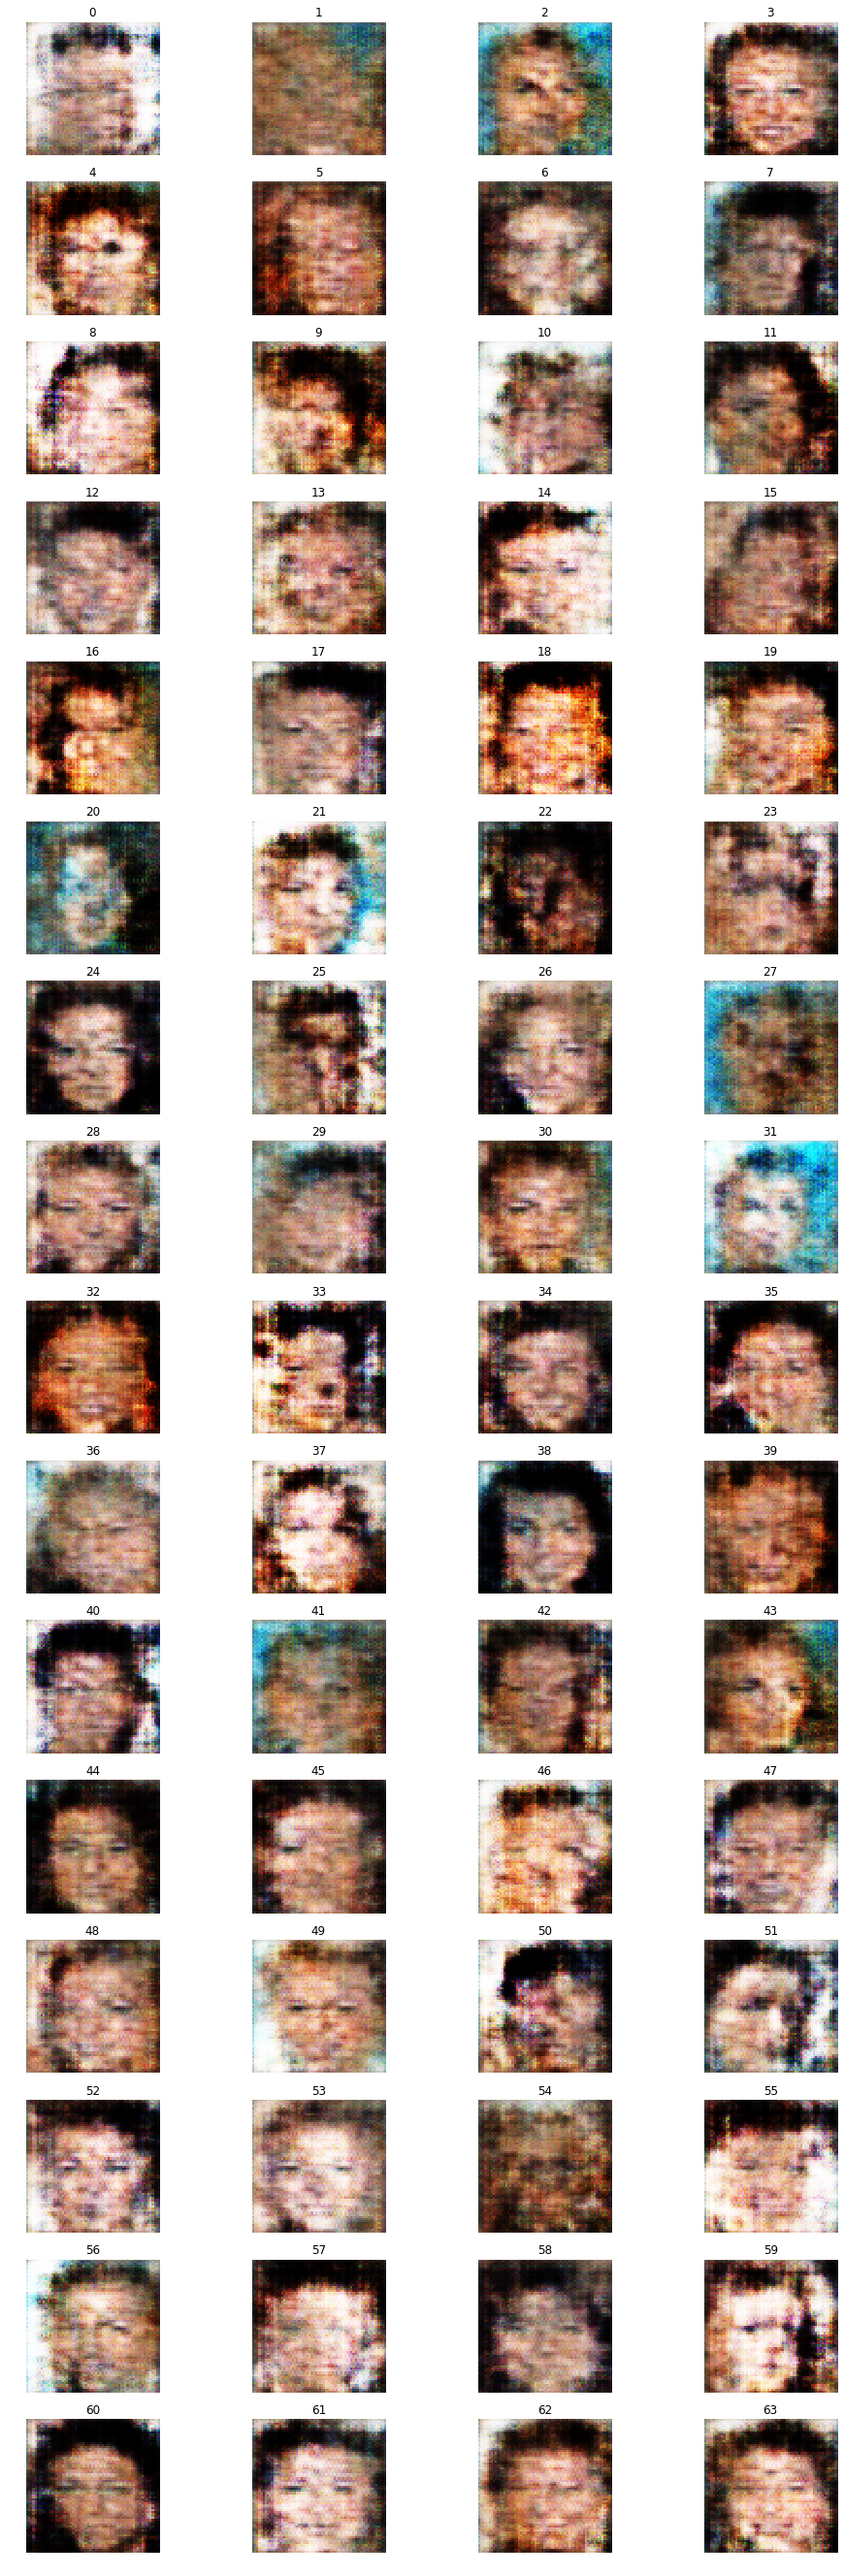

In [28]:
batchz = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)
samples = sess.run(G, feed_dict={z: batchz, is_training: False})
plt.figure(figsize=(16, 48))
for i, sample in enumerate(samples):
    plt.subplot(16, 4, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow((255*inverse_transform(sample)).astype(np.uint8))
plt.show()

In [29]:
smiles=[3,4,9,12,14,19,28,39,33,40,46,44,61]
no_smiles=[6,11,18,20,24,38,2,35]
smile_mean=np.zeros_like(batch_z[0])

for smile in smiles:
    smile_mean+=batch_z[smile]
smile_mean/=len(smiles)
no_smile_mean=np.zeros_like(batch_z[0])
for no_smile in no_smiles:
    no_smile_mean+=batch_z[no_smile]
no_smile_mean/=len(no_smiles)

smile_vector=smile_mean-no_smile_mean

added_smile_z=batch_z+smile_vector
added_smile_z=np.clip(a=added_smile_z,a_max=1.0,a_min=-1.0)

added_smile_samples=sess.run(G, feed_dict={z: added_smile_z, is_training: False} )

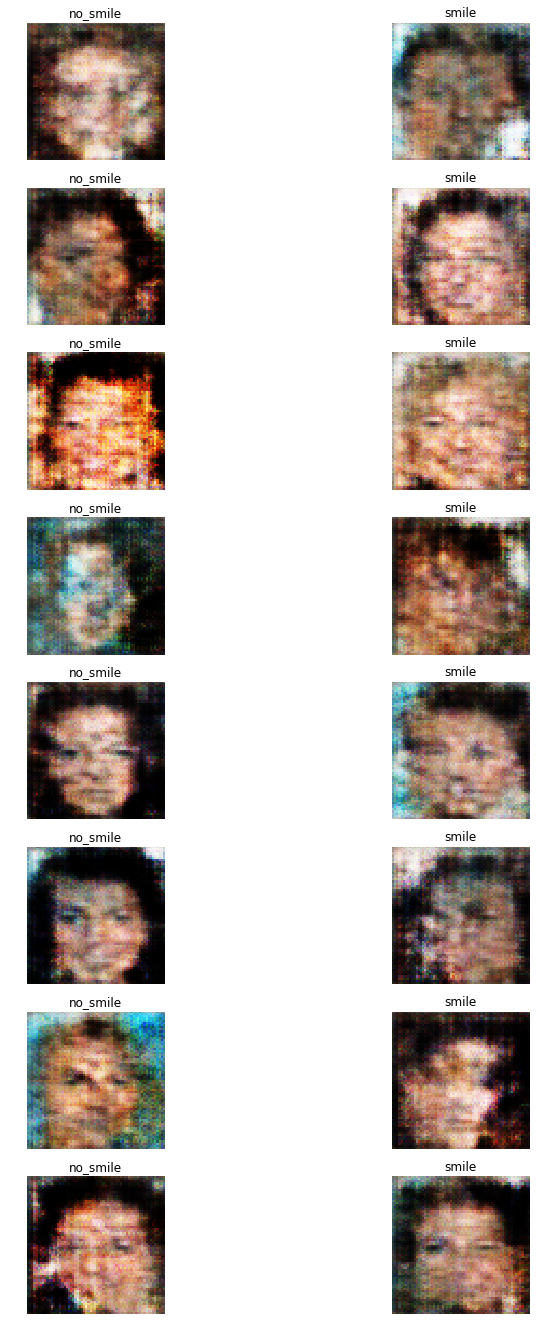

In [30]:
plt.figure(figsize = (12,48))
counter=1
for j in no_smiles:
    plt.subplot(16,2,counter)
    plt.axis('off')
    plt.title("no_smile")
    plt.imshow((255*inverse_transform(samples[j])).astype(np.uint8))
    counter+=1
    plt.subplot(16,2,counter)
    plt.axis('off')
    plt.title("smile")
    plt.imshow((255*inverse_transform(added_smile_samples[j])).astype(np.uint8))
    counter+=1 
plt.show() 

If faces looks really cool, add bonus 1 point to your score.